# Customer Churn Modeling

This Notebook shows a **step-by-step churn prediction workflow**:

- Load & preprocess data (split features, target, numeric/categorical)  
- Baseline model: Logistic Regression  
- Advanced model: XGBoost + hyperparameter tuning  
- Evaluation: metrics table, confusion matrices, feature importance  

**Goal:** Catch churners effectively while balancing **recall vs precision**.

In [1]:
# Load Data
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("../data/processed/clean_customer_churn.csv")

In [2]:
# Split Features & Target
from modeling import split_features 

TARGET_COL = "Churn"    # define target column
ID_COL = "customerID"   # define identifier column

# get X (features), y (target), numeric and categorical columns
X, y, num_features, cat_features = split_features(df, TARGET_COL, ID_COL)

In [3]:
# Train/Test Split (80%/20%)
from sklearn.model_selection import train_test_split 

y = y.map({"No": 0, "Yes": 1})  # convert target from Yes/No to binary 0/1

# split data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,                  # features and target
    test_size=0.2,         # 20% test set
    random_state=42,       # reproducible split
    stratify=y             # keep class distribution consistent
)

# print number of samples in train and test sets
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 5625, Test: 1407


--- Logistic Regression Results ---
Accuracy:  0.729
F1-score:  0.611
ROC-AUC:   0.835

Classification Report:
              precision    recall  f1-score   support

           0      0.906     0.704     0.792      1033
           1      0.494     0.799     0.611       374

    accuracy                          0.729      1407
   macro avg      0.700     0.752     0.702      1407
weighted avg      0.797     0.729     0.744      1407



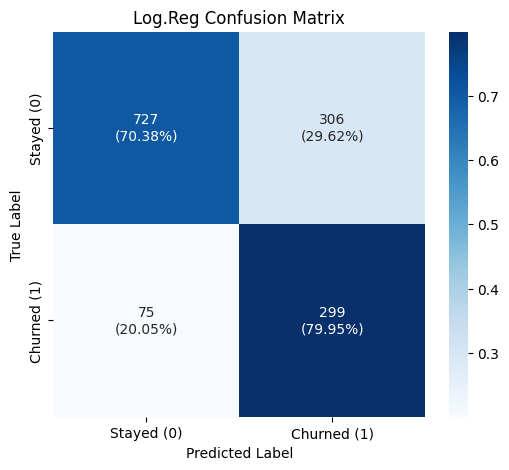

In [4]:
# Baseline Model: Logistic Regression
from modeling import build_logistic_pipeline
from evaluation import display_model_performance, custom_confusion_matrix, custom_roc_curve  

# create pipeline with preprocessing and logistic regression
log_pipeline = build_logistic_pipeline(num_features, cat_features)  
log_pipeline.fit(X_train, y_train)  # train the model on training data

y_pred = log_pipeline.predict(X_test)  # predict class labels on test set
y_proba = log_pipeline.predict_proba(X_test)[:, 1]  # predict probabilities for positive class

# evaluate Logistic Regression Base model
display_model_performance(y_test, y_pred, y_proba, "Logistic Regression")  
custom_confusion_matrix(y_test, y_pred, "Log.Reg Confusion Matrix")              

# Logistic Regression Insights
- **High recall (0.799) for churners** → model catches most churn cases
- **Moderate precision (0.494)** → ~50% of churn predictions are false positives
- **F1-score (0.611)** → balance between catching churners and avoiding false alarms
- **ROC-AUC (0.835)** → good class separation, overall stable performance
- **Next step** → try XGBoost to improve precision while maintaining high recall

--- XGBoost Base Results ---
Accuracy:  0.745
F1-score:  0.621
ROC-AUC:   0.834

Classification Report:
              precision    recall  f1-score   support

           0      0.904     0.730     0.808      1033
           1      0.513     0.786     0.621       374

    accuracy                          0.745      1407
   macro avg      0.709     0.758     0.714      1407
weighted avg      0.800     0.745     0.758      1407



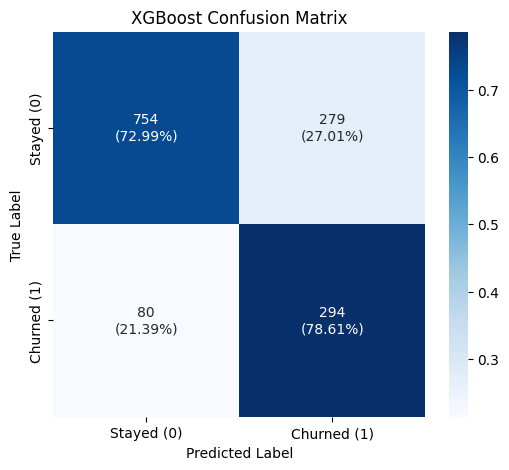

In [5]:
# Advanced Model: XGBoost
from modeling import build_xgboost_pipeline, tune_xgboost_hyperparameters, apply_threshold, save_model 

# calculate class imbalance ratio for scale_pos_weight
ratio = (y_train == 0).sum() / (y_train == 1).sum()  

# build XGBoost pipeline with preprocessing and class balancing
xgb_pipeline = build_xgboost_pipeline(num_features, cat_features, scale_pos_weight=ratio)
xgb_pipeline.fit(X_train, y_train)  # train XGBoost on training data

y_pred_xgb = xgb_pipeline.predict(X_test)  # predict class labels
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1] # predict probabilities for positive class

# evaluate base XGBoost model
display_model_performance(y_test, y_pred_xgb, y_proba_xgb, "XGBoost Base")  
custom_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")                       

# XGBoost Base Insights
- **Slightly higher accuracy (0.745) than Logistic Regression** → better overall predictions
- **Recall for churners remains high (0.786)** → still catching most churn cases
- **Precision improves slightly (0.513)** → fewer false positives than Logistic Regression
- **F1-score (0.621)** → small improvement in balance between precision and recall
- **ROC-AUC (0.834)** → class separation similar to Logistic Regression
- **Next step** → perform hyperparameter tuning to further improve precision and F1

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best F1: 0.6348
Best params: {'classifier__base_score': 0.5, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
--- XGBoost Tuned Results ---
Accuracy:  0.738
F1-score:  0.616
ROC-AUC:   0.841

Classification Report:
              precision    recall  f1-score   support

           0      0.905     0.718     0.801      1033
           1      0.504     0.791     0.616       374

    accuracy                          0.738      1407
   macro avg      0.705     0.755     0.708      1407
weighted avg      0.798     0.738     0.752      1407



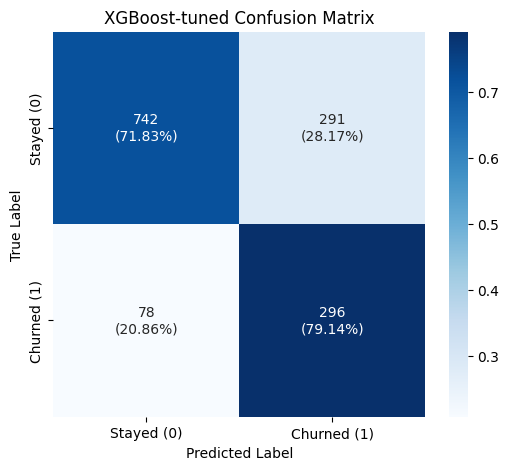

In [6]:
# Hyperparameter tuning

# perform GridSearchCV and get best pipeline
best_xgb = tune_xgboost_hyperparameters(xgb_pipeline, X_train, y_train)  

y_pred_best = best_xgb.predict(X_test)  # predict class labels with tuned model
y_proba_best = best_xgb.predict_proba(X_test)[:, 1] # predict probabilities for positive class

# Evaluate tuned XGBoost model
display_model_performance(y_test, y_pred_best, y_proba_best, "XGBoost Tuned") 
custom_confusion_matrix(y_test, y_pred_best, "XGBoost-tuned Confusion Matrix")      

# XGBoost Tuned Insights
- **Best F1 (0.635) achieved via GridSearchCV** → optimal combination of hyperparameters
- **Learning rate 0.01, 200 estimators, max_depth 5, subsample 0.8** → slower, gradual learning improved stability
- **Accuracy slightly lower (0.738) but ROC-AUC higher (0.841)** → better class separation
- **Recall for churners remains high (0.791)** → model still catches most churners
- **Precision (0.504) and F1 (0.616)** → improved trade-off over base XGBoost
- **Next step** → consider threshold adjustment for business objectives

--- XGBoost Custom Threshold Results ---
Accuracy:  0.692
F1-score:  0.601
ROC-AUC:   0.841

Classification Report:
              precision    recall  f1-score   support

           0      0.931     0.627     0.750      1033
           1      0.459     0.872     0.601       374

    accuracy                          0.692      1407
   macro avg      0.695     0.749     0.675      1407
weighted avg      0.805     0.692     0.710      1407



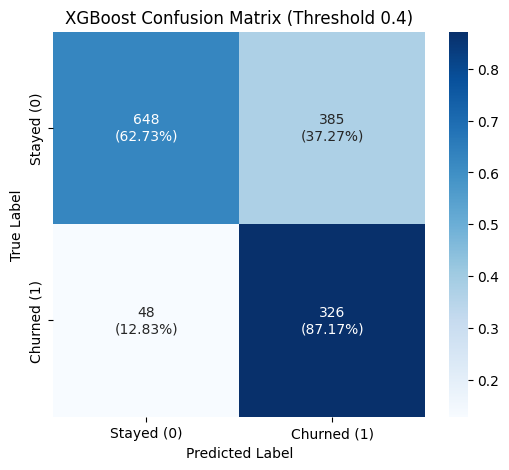

In [7]:
# Threshold Adjustment

y_pred_custom = apply_threshold(y_proba_best, threshold=0.4) # set custom threshold

# evaluate model with custom threshold
display_model_performance(y_test, y_pred_custom, y_proba_best, "XGBoost Custom Threshold")
custom_confusion_matrix(y_test, y_pred_custom, "XGBoost Confusion Matrix (Threshold 0.4)")

# XGBoost Custom Threshold (0.4) Insights
- **Recall jumps to 0.872 for churners** → more churn cases caught
- **Precision drops to 0.459** → more false positives as trade-off
- **F1-score 0.601** → balanced outcome considering higher recall
- **Accuracy drops (0.692) but ROC-AUC unchanged (0.841)** → class separation still strong
- **Business implication** → aggressive threshold helps retention, but increases unnecessary alerts
- **Next step** → adjust threshold based on marketing budget or risk tolerance

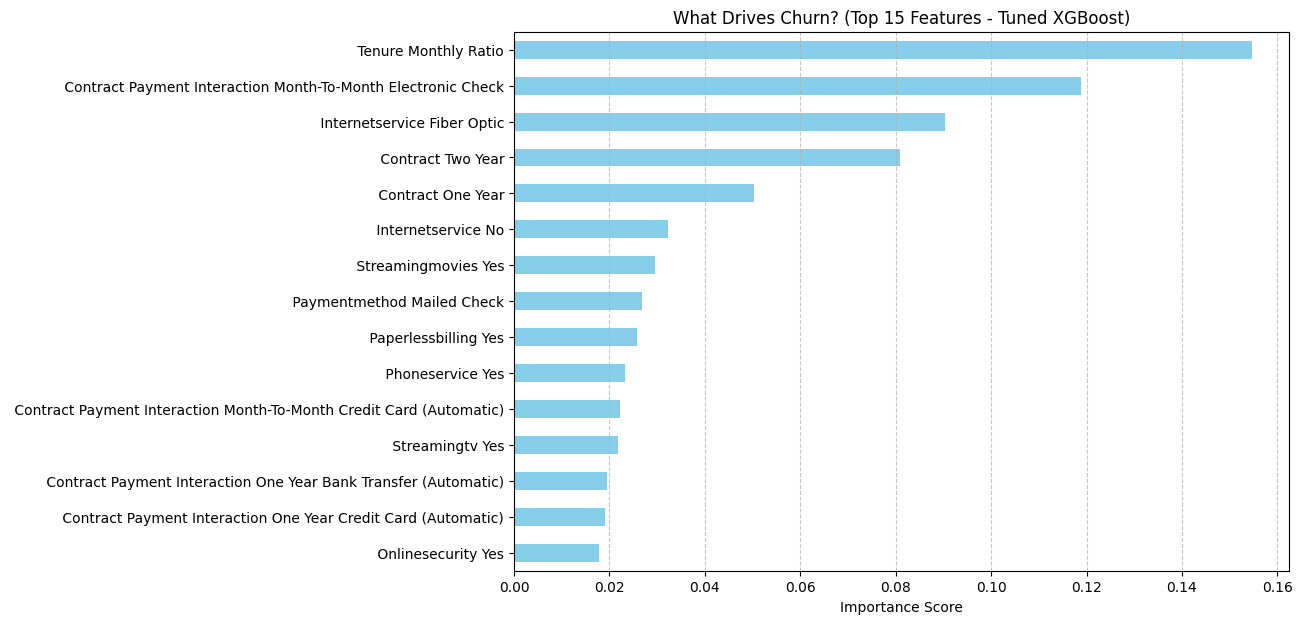

In [8]:
# Feature importance
from modeling import plot_feature_importance

plot_feature_importance(best_xgb, top_n=15, title="What Drives Churn? (Top 15 Features - Tuned XGBoost)")

In [9]:
from modeling import save_model

# FIX base_score for SHAP
clf = best_xgb.named_steps["classifier"]
clf.base_score = 0.5

# Save final model
save_model(best_xgb, '../models/churn_model_final_v1.joblib')

Model saved to: ../models/churn_model_final_v1.joblib


# Note on Custom Threshold
- We **do not save a separate model for threshold 0.4** because the pipeline itself (best_xgb) is unchanged.  
- The custom threshold is applied **only during inference** to adjust business-specific trade-offs between recall and precision.  
- This keeps the saved model **flexible** for future threshold adjustments without retraining.